In [1]:
using Revise
using Plots, LinearAlgebra
using Zygote, Convex, SCS

In [2]:
include("./src/eKF.jl")
include("./src/control_sampler.jl")

trajectory_pick (generic function with 1 method)

### Define the system dynamics and observation models

In [8]:
# calculate LQR cost:
η = 1 # Efficiency
Q_nom = 2.2 # Nominal capacity
dt = 1.0 # Discretization time
A = [1.0 0.0; 0.0 1.0]
B = dt * η / Q_nom * [1.0 0; 0 1.0]
n = size(A, 1) # Number of states
m = size(B, 2) # Number of inputs

function state_dynamics(SOC, I)
    SOC = A * SOC .+ B * I
    SOC = clamp.(SOC, 0.0, 1.0)
    return SOC
end

function measurement_dynamics(SOC)
    # LTO
    OCV_LTO = 2.5 + 0.3 * SOC[1] + 0.1 * tanh(8 * (SOC[1] - 0.5)) + 0.05 * sin(8 * π * SOC[1])   
    # LCO
    OCV_LCO = 3.7 + 0.5 * SOC[2] + 0.3 * sin(2 * π * SOC[2])

    OCV_Li = -43.1 * SOC[3]^6 + 155.4 * SOC[3]^5 - 215.7 * SOC[3]^4 + 146.6 * SOC[3]^3 - 50.16 * SOC[3]^2 + 8.674 * SOC[3] + 2.991
    
    OCV_EXP = 3.679*exp(-0.1101*SOC[4]) - 0.2528*exp(-6.829*SOC[4]) + 0.9386*SOC[4]^2
    return [OCV_LTO; OCV_LCO; OCV_Li; OCV_EXP]
end

W = 0.1 * [1.0 0.0; 0.0 1.0]
V = 0.1 * [1.0 0.0; 0.0 1.0];

### Visualize the observation models

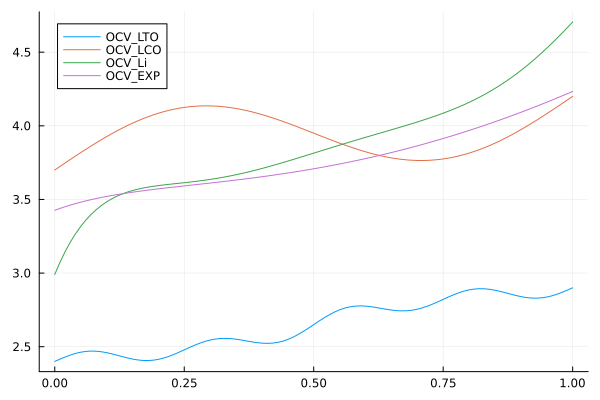

In [9]:
Ys = measurement_dynamics.([[i;i;i;i] for i in 0:0.01:1])
Ys = reduce(hcat, Ys)
plot(0:0.01:1, Ys[1,:], label="OCV_LTO")
plot!(0:0.01:1, Ys[2,:], label="OCV_LCO")
plot!(0:0.01:1, Ys[3,:], label="OCV_Li")
plot!(0:0.01:1, Ys[4,:], label="OCV_EXP")

### Define the extended Kalman Filter

In [23]:
eKF = ExtendedKalmanFilter(state_dynamics, measurement_dynamics, W, V)

ExtendedKalmanFilter(Main.state_dynamics, Main.measurement_dynamics, [0.1 0.0; 0.0 0.1], [0.1 0.0; 0.0 0.1])

### Initialize the control sampling object

In [24]:
N = 8 # prediction horizon length
Q = 1.0
R = 0.1 * I(m)
set_point = 0.7
running_cost = (x, cov, u) -> Q * (sum(x) - set_point)^2 + Q * tr(cov) + u' * R * u
CS = ControlSampler(eKF, N, running_cost)

ControlSampler(ExtendedKalmanFilter(Main.state_dynamics, Main.measurement_dynamics, [0.1 0.0; 0.0 0.1], [0.1 0.0; 0.0 0.1]), 8, var"#101#102"())

### Initialize the model predictive control solver and the simulation loop

In [25]:
include("./src/mpc.jl")
include("./simulate.jl")

simulate_mpc (generic function with 1 method)

In [ ]:
x₀₀ = [0.2; 0.2]
Σ₀₀ = 0.1 * Matrix{Float64}(I, 2, 2)
L = 50
num_simulations = 20
T = 50

cost_rec = zeros(num_simulations)
est_err_rec = zeros(num_simulations)
x_rec = zeros(n, T, num_simulations)
u_rec = zeros(m, T, num_simulations)
x_true_rec = zeros(n, T, num_simulations)


function simulation_run()
    X_rec, U_rec, _, X_true_rec = simulate_CS(x₀₀, Σ₀₀, T, L; u_noise_cov = 0.01)
    achieved_cost = sum([CS.running_cost(X_true_rec[k], 0, U_rec[k]) for k in 1:T]) / T
    achieved_est_err = sum([norm(X_rec[k] - X_true_rec[k]) for k in 1:T]) / T
    return achieved_cost, achieved_est_err, X_rec, U_rec, X_true_rec
end
for i in 1:num_simulations
    println("Simulation: ", i)
    if i==num_simulations
        @time begin
        achieved_cost, achieved_est_err, X_rec, U_rec, X_true_rec = simulation_run()
        end
    else
        achieved_cost, achieved_est_err, X_rec, U_rec, X_true_rec = simulation_run()
    end
    cost_rec[i] = achieved_cost
    est_err_rec[i] = achieved_est_err
end
println("Average Achieved Cost: ", sum(cost_rec) / num_simulations)
println("Average Achieved Estimation Error: ", sum(est_err_rec) / num_simulations)

Simulation: 1
[[0.2, 0.2], [0.3136759784472701, 0.43549414599066916], [0.12697777969631363, 0.3786922378225688], [0.7067810211591125, 0.012884371997852861], [0.5931163372514304, 0.23204199858886035], [0.6521368553258811, 0.08585016360950613], [0.575524876617898, 0.31270758831546874], [0.8000978816456359, 0.3633225005848675], [0.5749488302639718, 0.4073217653861124], [0.6157542244341553, 0.1324926272024634], [0.6009712450211419, 0.08159049697086665], [0.5183542339650958, 0.14279626091395647], [0.04331655310240584, 0.02419078344972085], [0.33104913608980235, 0.42398813873570856], [0.4019387665444772, 0.3609012294582189], [0.7814127845108906, 0.6095487944534673], [0.47045158133061865, 0.18163711787135808], [0.348230447801801, 0.0], [0.25458591607303815, 0.0], [0.2867293118615648, 0.0], [0.536059860548127, 0.1636240537081392], [0.5178154351254955, 0.0], [0.3371755916966489, 0.05842654857445919], [0.3457062408924233, 0.058082141451644004], [0.23077257711719984, 0.0], [0.6590674467098074, 0.

In [30]:
# plot(x_true_rec[1, :, 1], x_true_rec[2, :, 1], label="True State", legend=:topleft)
print(x_true_rec[1, :, 1])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [27]:
cost_rec_mpc = zeros(num_simulations)
est_err_rec_mpc = zeros(num_simulations)
x_rec_mpc = zeros(n, T, num_simulations)
u_rec_mpc = zeros(m, T, num_simulations)
x_true_rec_mpc = zeros(n, T, num_simulations)

function simulate_run_mpc()
    X_rec_mpc, U_rec_mpc, _, X_true_rec_mpc = simulate_mpc(x₀₀, Σ₀₀, T)
    achieved_cost = sum([CS.running_cost(X_true_rec_mpc[k], 0, U_rec_mpc[k]) for k in 1:T]) / T
    achieved_est_err = sum([norm(X_rec_mpc[k] - X_true_rec_mpc[k]) for k in 1:T]) / T
    return achieved_cost, achieved_est_err 
end
for i in 1:num_simulations
    achieved_cost, achieved_est_err = simulate_run_mpc()
    cost_rec_mpc[i] = achieved_cost
    est_err_rec_mpc[i] = achieved_est_err
end
println("Average Achieved Cost: ", sum(cost_rec_mpc) / num_simulations)
println("Average Achieved Estimation Error: ", sum(est_err_rec_mpc) / num_simulations)

Average Achieved Cost: 0.3242558881208025
Average Achieved Estimation Error: 0.5263307287361993


### Calculating changes/improvements (-ve is good)

In [28]:
println("Average Achieved Cost Change: % ", (sum(cost_rec)-sum(cost_rec_mpc)) / sum(cost_rec_mpc) * 100)
println("Average Achieved Estimation Error Change: % ", (sum(est_err_rec) - sum(est_err_rec_mpc)) / sum(est_err_rec_mpc) * 100)

Average Achieved Cost Change: % -13.051575145541754
Average Achieved Estimation Error Change: % -15.07208349465553
